# <center>Conformal Prediction of Stock Prices</center>
This project examines Stock prices of the XXX stock for the period YYY, then tries to predict their future prices using traditional methods such as ARIMA modelling.  Additionally, we use Conformal prediction to ascertain the accuracy of the prediction




Date: April 9th, 2024



Authors: Rohit Vernekar & A. Walker


# <center>Abstract</center>

The price of a stock indicates its current value to buyers and sellers. It gives insight into a company's current market value.  However, the stock's intrinsic value may be higher or lower.
The challenge of a stock investor is to identify stocks that are currently undervalued by the market to be able to take advantage of favourable price changes in the future.
In this presentation, we examine Stock prices and try to find a model that could predict the future prices to a great degree of accuracy.  We incorporate the use of Conformal Prediction to establish bounds on the predictions


In [ ]:
# import libraries
import sklearn
import time 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import warnings
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

In [ ]:
#check for outliers in the data, remove anything more that 3 std dev away
def testOutlierRemovalAndIdentification(time_series_data):
    # Calculate z-scores for each data point
    z_scores = (time_series_data - time_series_data.mean()) / time_series_data.std()

    # Define a threshold for outlier detection (e.g., z-score > 3 or < -3)
    outlier_threshold = 3

    # Identify outliers
    outliers = time_series_data[abs(z_scores) > outlier_threshold]

    # Remove outliers from the time series data
    filtered_data = time_series_data.drop(outliers.index)

    # Plot the original time series data and the filtered data
    plt.figure(figsize=(10, 6))
    plt.plot(time_series_data.index, time_series_data, label='Original Data', color='blue')
    plt.scatter(outliers.index, outliers, color='red', label='Outliers')
    plt.plot(filtered_data.index, filtered_data, label='Filtered Data', color='green')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Time Series Data with Outliers Removed')
    plt.legend()
    plt.show()

    # Print the number of removed outliers
    print(f"Number of removed outliers: {len(outliers)}")
    return filtered_data

In [ ]:

# test for Stationarity by executing Augmented DickeyFuller test, p-value < 0.05 will indicate stationarity
def stationarityTest(dataToTest):
    # adftest = adfuller(data['GDP'], autolag='AIC', regression='ct')
    adftest = adfuller(dataToTest, autolag='AIC', regression='ct')
    print("ADF Test Results")
    print("Null Hypothesis: The series has a unit root (non-stationary)")
    print("ADF-Statistic:", adftest[0])
    print("P-Value:", adftest[1])
    print("Number of lags:", adftest[2])
    print("Number of observations:", adftest[3])
    print("Critical Values:", adftest[4])
    print("Note: A P-Value less than 0.05, results in rejecting the null hypothesis, conclusion the series is stationary")

# Test Stationarity by performing the KPSS test, a p-value > 0.05 will indicate stationarity
def stationarityKPSS(dataToTest):
    result = kpss(dataToTest.squeeze())
    # result = kpss(dataToTest, regression='c')
    print('\nKPSS Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[3].items():
        print('Critical Vals:')
        print(f'   {key}, {value}')
    print('KPSS test:\tp-value: {:.3f}'.format(result[1]))

# test ACF to check stationarity
def plotACF(dataToTest):
    # plot_acf(data['GDP'], lags=20)
    plot_acf(dataToTest, lags=20)
    plt.title("Autocorrelation Function (ACF)")
    plt.xlabel("Lags")
    plt.ylabel("ACF Value")
    plt.show()

In [9]:
from datetime import date
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import torch

In [76]:

market_data = yf.download (tickers = "^GSPC", start = "2022-01-01", end = pd.Timestamp.today(), interval = "1d") # start="1927-12-30"
market_data["pct_change"] = market_data["Close"].pct_change()
market_data['date_ordinal'] = pd.to_datetime(market_data.index.to_series()).apply(lambda date: date.toordinal())
market_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,pct_change,date_ordinal
Date,,,,,,,,
2022-01-03,4778.140137,4796.640137,4758.169922,4796.560059,4796.560059,3831020000,NaN,738158
2022-01-04,4804.509766,4818.620117,4774.270020,4793.540039,4793.540039,4683170000,-0.000630,738159
2022-01-05,4787.990234,4797.700195,4699.439941,4700.580078,4700.580078,4887960000,-0.019393,738160
2022-01-06,4693.390137,4725.009766,4671.259766,4696.049805,4696.049805,4295280000,-0.000964,738161
2022-01-07,4697.660156,4707.950195,4662.740234,4677.029785,4677.029785,4181510000,-0.004050,738162


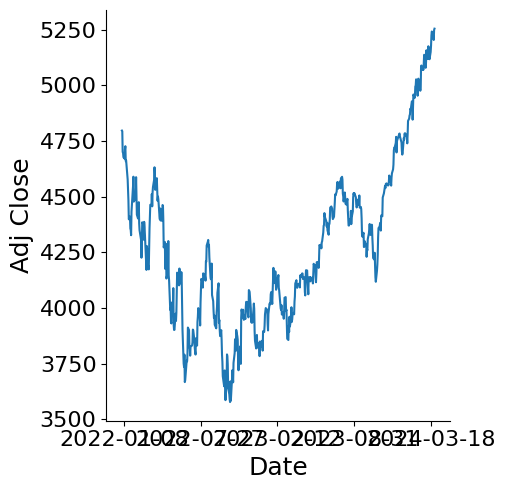

In [77]:
sns.relplot(market_data, x="Date", y="Adj Close", kind="line")
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))

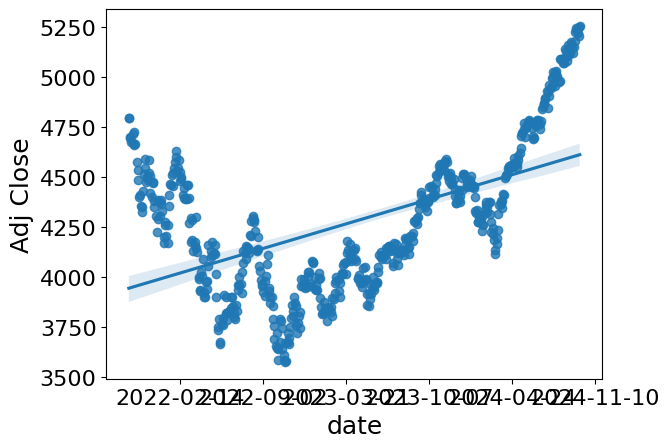

In [78]:
ax = sns.regplot(market_data, x="date_ordinal", y="Adj Close")
ax.set_xlabel('date')
new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
_ = ax.set_xticklabels(new_labels)
ax.xaxis.set_major_locator(plt.MaxNLocator(6))

In [79]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(market_data["date_ordinal"], market_data["Adj Close"], test_size=30/market_data.shape[0], shuffle=False)
X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)
X_test.shape

((30, 1),
 array([[738931],
        [738932],
        [738936],
        [738937],
        [738938],
        [738939],
        [738942],
        [738943],
        [738944],
        [738945],
        [738946],
        [738949],
        [738950],
        [738951],
        [738952],
        [738953],
        [738956],
        [738957],
        [738958],
        [738959],
        [738960],
        [738963],
        [738964],
        [738965],
        [738966],
        [738967],
        [738970],
        [738971],
        [738972],
        [738973]]))

In [80]:
# Fitting polynomial regression model

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(3)
poly_x_train = poly.fit_transform(X_train)
poly_x_train.shape

(532, 4)

In [81]:
poly_x_test = poly.transform(X_test)
poly_x_test.shape

(30, 4)

In [82]:
X_train = poly_x_train
X_test = poly_x_test

In [83]:
# Fitting linear regression model

from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)

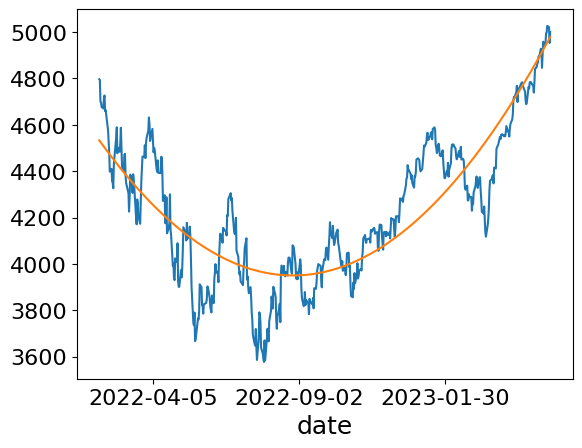

In [84]:
plt.plot(market_data.iloc[:-30]["date_ordinal"].values.reshape(-1, 1) , y_train)
y_pred = reg.predict(X_train)
plt.plot(market_data.iloc[:-30]["date_ordinal"].values.reshape(-1, 1) , y_pred)
plt.gca().set_xlabel('date')
new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
plt.gca().set_xticklabels(new_labels)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(4))

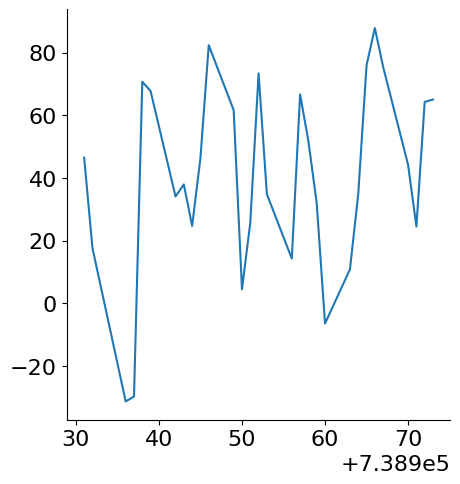

In [88]:
# Plotting residuals
y_pred = reg.predict(X_test)
residuals = y_test - y_pred
sns.relplot(x = market_data.iloc[-30:]["date_ordinal"].values.reshape(-1, 1)[:, 0], y = residuals[:, 0], kind="line")

### To use [SPCI](https://arxiv.org/abs/2212.03463), which performs better (i.e., intervals are narrower) but slower

In general, just pass in `X_full, Y_full` which are torch.tensor and specify what are the training samples and test samples by changing `train_frac`. Also, adjust `past_window` to specify the amount of past residuals to use when constructing intervals. 

For SPCI, larger `past_window` may or may not be better, depending on if there are "shifts" in the data distribution.

In [89]:
# Initialize the SPCI class
import SPCI_class as SPCI
SPCI_class_  = SPCI.SPCI_and_EnbPI(
    torch.from_numpy(X_train), 
    torch.from_numpy(X_test), 
    torch.from_numpy(y_train.reshape(-1)), 
    torch.from_numpy(y_test.reshape(-1)), 
    fit_func=reg)
stride = 1
SPCI_class_.fit_bootstrap_models_online_multistep(
            B = 25, fit_sigmaX=False, stride=stride)
alpha = 0.1 # 90% prediction interval

1/1 multi-step: finish Fitting 25 Bootstrap models, took 0.03400683403015137 secs.


In [90]:
past_window = 30
use_SPCI = True
smallT = not use_SPCI
SPCI_class_.compute_PIs_Ensemble_online(
    alpha, smallT=smallT, past_window=past_window, use_SPCI=use_SPCI,
    quantile_regr=True, stride=stride)
results = SPCI_class_.get_results(alpha, 'my_data', 1)

Shape of slided residual lists is (30, 532)
Width at test 0 is 185.4704933166504
Width at test 1 is 180.4110221862793
Width at test 2 is 179.21537017822266
Width at test 3 is 205.27500915527344
Width at test 4 is 215.35235595703125
Width at test 5 is 182.61471939086914
Width at test 6 is 179.00455856323242
Width at test 7 is 179.65157318115234
Width at test 8 is 181.54159927368164
Width at test 9 is 182.881591796875
Width at test 10 is 178.16424560546875
Width at test 11 is 180.9256591796875
Width at test 12 is 185.4560775756836
Width at test 13 is 181.3138656616211
Width at test 14 is 180.49863052368164
Width at test 15 is 172.3831443786621
Width at test 16 is 180.00685119628906
Width at test 17 is 179.8327980041504
Width at test 18 is 173.77205276489258
Width at test 19 is 180.20316314697266
Width at test 20 is 178.5571403503418
Width at test 21 is 174.62395095825195
Width at test 22 is 175.11667442321777
Width at test 23 is 181.29813766479492
Width at test 24 is 155.73928451538086
W

Text(0.5, 1.0, 'Target coverage is 90.00%. \n Actual coverage is 100.00% \n Average interval width is 178.47')

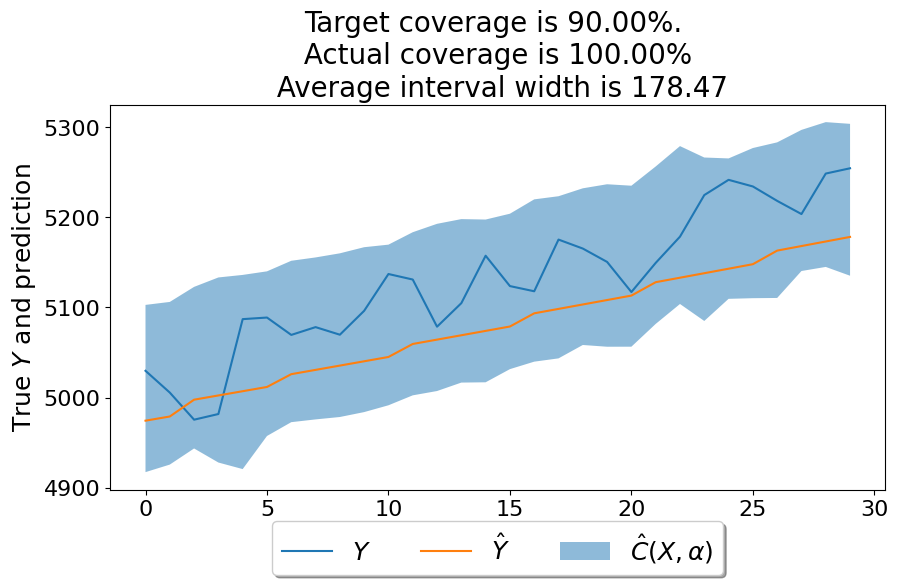

In [91]:
# Plot prediction intervals on test sample
Pred_ints = SPCI_class_.PIs_Ensemble
Y_est = SPCI_class_.Ensemble_pred_interval_centers
Y_predict = SPCI_class_.Y_predict.numpy()
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 5))
plt.plot(Y_predict, label=r'$Y$')
plt.plot(Y_est, label=r'$\hat{Y}$')
plt.fill_between(np.arange(len(Y_predict)), Pred_ints['lower'], Pred_ints['upper'], alpha=0.5, label=r'$\hat{C}(X,\alpha)$')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
           fancybox=True, shadow=True, ncol=3)
plt.xlabel('Test time index')
plt.ylabel('True $Y$ and prediction')
actual_cov = 100*results["coverage"].item()
actual_wid = results["width"].item()
plt.title(f'Target coverage is {100*(1-alpha):.2f}%. \n Actual coverage is {actual_cov:.2f}% \n Average interval width is {actual_wid:.2f}')